### An overview of HBAI BHC (regional) data
In this notebook we examine how HBAI low income groups changes in different regions in the UK in the years 1994-2023.

HBAI (Households below average income ) -relative low income if their net household income is below a threshold set at 60% of median income.

Income includes :
- Earnings from Employment (Wages, Self-Employment Income, Pandemic Support Schemes)
- Benefits and Tax Credits: Cash Benefits, Tax Credits
- Pension Payments: State Pension payments for retirees.
- Cost of Living Payments
- Income from Savings and Investments
- Rental Income: Income from renting out property, after expenses but before taxes.
- Private Pensions and Annuities
- Child Maintenance Payments: Regular payments received for child support.



In [2]:
import pandas as pd

import plotly.express as px
import sys



def read_csv(data_file):

    # Read the CSV file, skipping the first row (header row) and unnecessary footer rows
    df = pd.read_csv(data_file, skiprows=1, skipfooter=0, engine='python')

    # Drop empty columns and rows
    df = df.dropna(how='all', axis=1).dropna(how='all', axis=0)
    #print(df)
    # Extract the year column and clean it
    df['Financial Year'] = df['Financial Year'].str.extract(r'(\d{4}-\d{2})')
    df = df.dropna(subset=['Financial Year'])
    #print(df.head(5))
    # Set the year as the index
    df.set_index('Financial Year', inplace=True)

    # extract data columns.
    total_col_index = df.columns.str.contains('Total').argmax()
    not_low_income = df.iloc[:, :total_col_index].add_suffix('-not low income')

    # clean up the duplcated 1. 2. column names
    df.columns = df.columns.str.replace(r'\.\d+$', '', regex=True)
    
    low_income = df.iloc[:, total_col_index + 1: total_col_index *2+1 ].add_suffix('-low income')

    total_columns = df.iloc[:, total_col_index *2 +2:].add_suffix('-total')

    # Combine the two groups of columns
    result = pd.concat([not_low_income, low_income, total_columns], axis=1)

    # Save or display the resulting DataFrame
    #print(result.head())  # Display the first few rows
    result.to_csv(data_file+"_processed.csv")  # Save to a new CSV file
    #print(df.head())
    print("----")    

    # convert to numbers
    result = result.apply(pd.to_numeric, errors='coerce')
    #print(result.head(10))
    return result, low_income.columns






In [3]:

BHC, regions=read_csv("./HBAI-BHC-Region.csv")

----


In [4]:
region_list=list(regions.str.replace('-low income',''))

region_list

['Northern Ireland (N92000002)',
 'Scotland (S92000003)',
 'Wales (W92000004)',
 'North East (E12000001)',
 'North West (E12000002)',
 'Yorkshire and The Humber (E12000003)',
 'East Midlands (E12000004)',
 'West Midlands (E12000005)',
 'East (E12000006)',
 'London (E12000007)',
 'South East (E12000008)',
 'South West (E12000009)']

In [11]:
def extract_and_fix_year(year_range):
    try:
        year_suffix = year_range.split('-')[1]
        full_year = "20" + year_suffix  if int(year_suffix) < 50 else "19" +year_suffix
        return int(full_year) 
    except:
        return None


def plot_hbai_trends(bhc_df, region_list):

    # Calculate the impact (AHC - BHC) for each region
    for region in region_list:
        print(region)
        bhc_df[f'{region} pct'] = (bhc_df[f'{region}-low income']/bhc_df[f'{region}-total'])*100

    region_pct_cols = [f'{region} pct' for region in region_list]
    bhc_df=bhc_df.reset_index()
    # Melt the data to long format for easier plotting (if needed)
    impact_data = bhc_df.melt(
        id_vars=['Financial Year'],
        value_vars=region_pct_cols,
        var_name='Region',
        value_name='Percentage of HBAI'
    )
    impact_data['Financial Year'] = impact_data['Financial Year'].apply(extract_and_fix_year)

    impact_data.to_csv("./temp.csv")
    # Create the line chart
    fig = px.line(impact_data, 
                x='Financial Year', 
                y='Percentage of HBAI', 
                color='Region',
                title='Household below average income (before housing costs) by Region , 1994-2023',
                labels={'Percentage of HBAI':'percentage', 'Financial Year': 'Year'},
                hover_data=['Region'],
                width=1200, height=600)

    # Customize the layout (optional)
    fig.update_layout(
        xaxis_title="Year",
        yaxis_title="Percentage of HBAI (%)",
        legend_title="Region",
        hovermode="x unified"  # Shows data for all regions at a given year
    )
    #fig.add_annotation(
    #    text="Note: percentage is calculated by (low income BHC in region-low income AHC in region)/total BHC in region.",
    #    xref="paper", yref="paper",  # Relative to the entire plot
    #    x=0.5, y=-0.2,  # Position below the plot
    #    showarrow=False,
    #    font=dict(size=12, color="gray")
    #)

    # Show the plot
    fig.show()
    #fig.write_html("HBAI_by_region.html")

    import plotly.io as pio
    pio.write_image(fig, 'chart.png')  # Save the figure as an image

    from IPython.display import display, Image
    display(Image(filename='chart.png'))

Northern Ireland (N92000002)
Scotland (S92000003)
Wales (W92000004)
North East (E12000001)
North West (E12000002)
Yorkshire and The Humber (E12000003)
East Midlands (E12000004)
West Midlands (E12000005)
East (E12000006)
London (E12000007)
South East (E12000008)
South West (E12000009)


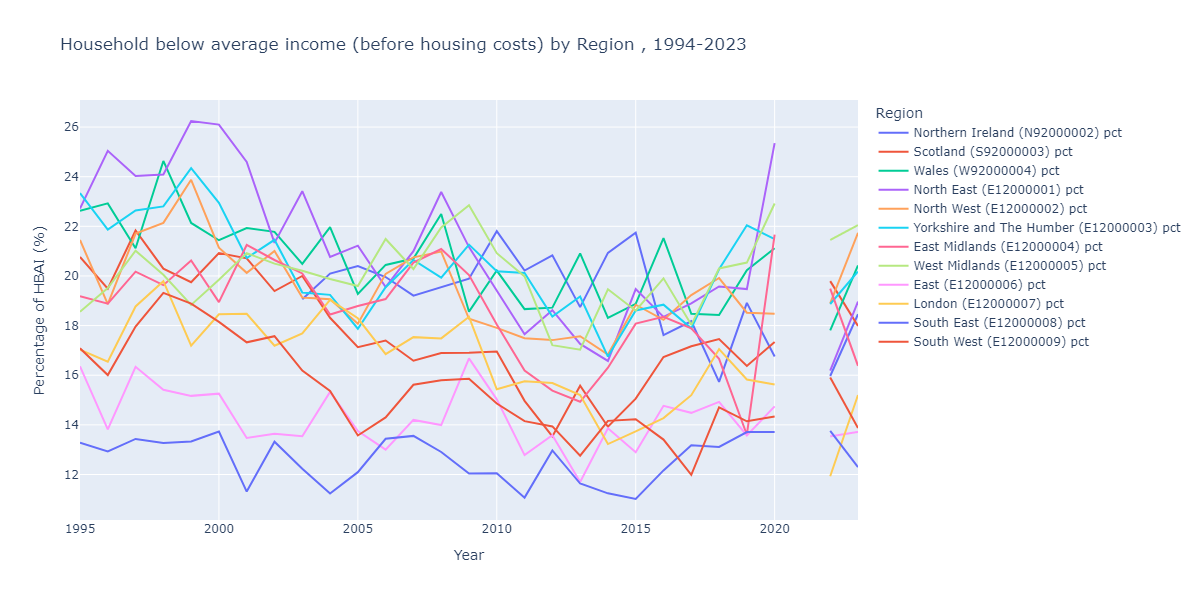

In [12]:

plot_hbai_trends(BHC, region_list)

### Observations

Overall a downtrend in the % of population in below average income.  The fluctuations in the percentage might be related to to major economic events:
- Late 1990s to Early 2000s: Many regions see a slight decline in poverty rates, possibly due to economic growth and welfare reforms during this period.
- 2008-2010 (Global Financial Crisis):  noticeable increase in poverty rates across most regions around 2008-2010.   it  reflects the economic downturn’s impact on employment and income levels.
- Post-2010 Recovery: After 2010, poverty rates generally resume their downward trend, though some regions (e.g., London, North East) show slower declines or temporary increases around 
- 2015-2018, possibly due to austerity measures or wage stagnation.
- 2020-2023 (Post-COVID): There’s a data gap in 2020-2021 (as seen in the previous chart), but by 2021-2023, the downward trend continues, with some regions like the South East and South West reaching their lowest poverty rates (around 12-13%).

Action: Government could prepare for such fluctuations by building flexible programs (e.g., emergency funds, rapid-response job support) that can address sudden increases in poverty during economic downturns.  We should also teach people to spend wisely and to save, however small, to build up their own emergence funds.


